## 1. Quá trình dự báo trên mô hình ARIMA

# Thêm thư viện

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pmdarima as pmd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error
from sklearn.utils import column_or_1d
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import load_model

# Nạp dữ liệu từ file csv

In [2]:
df = pd.read_csv('ethereum.csv')
df.pop('Currency')
df.pop('Volume')
df.pop('High')
df.pop('Low')
df.pop('Close')

df['Date'] = pd.to_datetime(df['Date'])
df.set_index("Date",inplace=True)
df_close = df['Open'].values.reshape(-1, 1)

df

,Open
Date,
2020-06-01,0.23180
2020-06-02,0.24801
2020-06-03,0.23790
2020-06-04,0.24453
2020-06-05,0.24337
...,...
2022-05-28,1.72467
2022-05-29,1.79225
2022-05-30,1.81356


# Chuẩn hóa dữ liệu

In [3]:
arima_sc = StandardScaler()

df_scaled = df.copy()
df_scaled['Open'] = arima_sc.fit_transform(df_close)
df_scaled

,Open
Date,
2020-06-01,-1.394670
2020-06-02,-1.382460
2020-06-03,-1.390075
2020-06-04,-1.385081
2020-06-05,-1.385955
...,...
2022-05-28,-0.270140
2022-05-29,-0.219234
2022-05-30,-0.203182


# Vẽ đồ thị

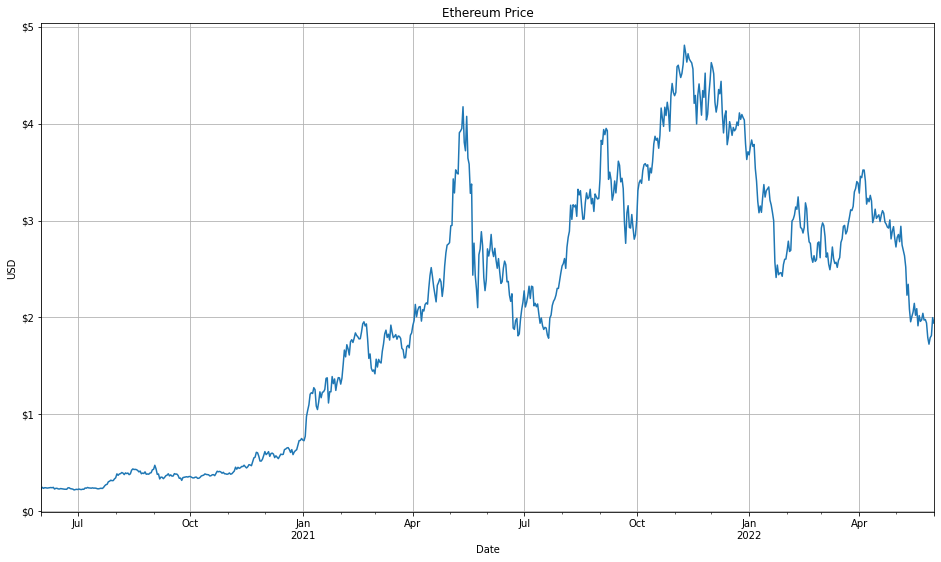

In [4]:
# Thư viện vẽ đồ thị
formatter = ticker.StrMethodFormatter('${x:,.0f}')

title = 'Ethereum Price'
ylabel = 'USD'
xlabel = 'Date'

ax = df['Open'].plot(figsize=(16, 9), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True)

# Tách dữ liệu thành tập train và test

In [5]:
train, test = df_scaled[:(int)(len(df_scaled) * 0.8)], df_scaled[(int)(len(df_scaled) * 0.8):]
index_test = df_scaled.index[(int)(len(df_scaled) * 0.8):]
print('train shape: ', train.shape)
print('test shape: ', test.shape)

train shape:  (584, 1)
test shape:  (147, 1)


# Hàm kiểm định chuỗi dừng

In [6]:
def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    # .dropna() handles differenced data
    result = adfuller(series.dropna(), autolag='AIC')

    labels = ['ADF test statistic', 'p-value',
              'Number of lags used', 'Number of observations']
    out = pd.Series(result[0:4], index=labels)

    for key, val in result[4].items():
        out[f'critical value ({key})'] = val

    # .to_string() removes the line "dtype: float64"
    print(out.to_string())

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non stationary")

# Kiểm định tính dừng của chuỗi

In [7]:
adf_test(train['Open'],'Ethereum Price')

Augmented Dickey-Fuller Test: Ethereum Price
ADF test statistic         -0.905245
p-value                     0.786240
Number of lags used         6.000000
Number of observations    577.000000
critical value (1%)        -3.441734
critical value (5%)        -2.866562
critical value (10%)       -2.569445
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non stationary


nhận thấy p-value > 0.05, do đó chuỗi không phải là chuỗi dừng

# Tính sai phân bậc 1 (d = 1) của chuỗi để kiểm định tính dừng

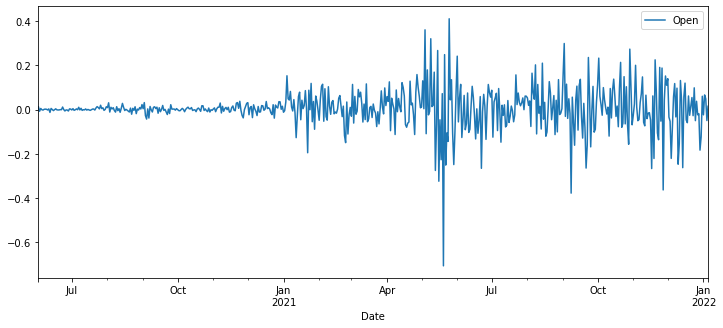

In [8]:
diff_1 = train.diff().dropna()
diff_1.plot(figsize=(12,5));

# Kiểm định tính dừng của chuỗi tại sai phân bậc 1

In [9]:
adf_test(diff_1, 'Ethereum Price First Difference')

Augmented Dickey-Fuller Test: Ethereum Price First Difference
ADF test statistic       -9.081637e+00
p-value                   4.041361e-15
Number of lags used       5.000000e+00
Number of observations    5.770000e+02
critical value (1%)      -3.441734e+00
critical value (5%)      -2.866562e+00
critical value (10%)     -2.569445e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Nhận thấy p-value < 0.05, do đó chuỗi có tính dừng tại sai phân bậc 1

In [10]:

def ArimaModel(timeseriesarray):
    autoarima_model = pmd.auto_arima(timeseriesarray, 
                              test="adf",
                              seasonal=False,
                              trace=True)
    return autoarima_model

In [11]:
arima_model = ArimaModel(train)
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1149.253, Time=0.96 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1144.790, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1152.253, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1152.041, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1145.287, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1150.264, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1150.268, Time=0.48 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1148.261, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-1152.323, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-1150.357, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1150.371, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1152.063, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-1148.353, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 2.587 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  584
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 578.161
Date:                Mon, 27 Jun 2022   AIC                          -1152.323
Time:                        00:26:47   BIC                          -1143.586
Sample:                             0   HQIC                         -1148.917
                                - 584                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1241      0.031     -4.020      0.000      -0.185      -0.064
sigma2         0.0081      0.000     38.561      0.000       0.008       0.008
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2079.43
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):              76.72   Skew:                            -0.90
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Dự đoán trên tập test

In [12]:
pred = arima_model.predict(len(test))
pred


array([1.27958456, 1.27981492, 1.27978633, 1.27978987, 1.27978943,
       1.27978949, 1.27978948, 1.27978948, 1.27978948, 1.27978948,
       1.27978948, 1.27978948, 1.27978948, 1.27978948, 1.27978948,
       1.27978948, 1.27978948, 1.27978948, 1.27978948, 1.27978948,
       1.27978948, 1.27978948, 1.27978948, 1.27978948, 1.27978948,
       1.27978948, 1.27978948, 1.27978948, 1.27978948, 1.27978948,
       1.27978948, 1.27978948, 1.27978948, 1.27978948, 1.27978948,
       1.27978948, 1.27978948, 1.27978948, 1.27978948, 1.27978948,
       1.27978948, 1.27978948, 1.27978948, 1.27978948, 1.27978948,
       1.27978948, 1.27978948, 1.27978948, 1.27978948, 1.27978948,
       1.27978948, 1.27978948, 1.27978948, 1.27978948, 1.27978948,
       1.27978948, 1.27978948, 1.27978948, 1.27978948, 1.27978948,
       1.27978948, 1.27978948, 1.27978948, 1.27978948, 1.27978948,
       1.27978948, 1.27978948, 1.27978948, 1.27978948, 1.27978948,
       1.27978948, 1.27978948, 1.27978948, 1.27978948, 1.27978

# Biến đổi giá trị dự đoán và thực tế về miền giá trị ban đầu

In [13]:
inv_test = arima_sc.inverse_transform(test.values.reshape(-1, 1))
inv_pred = arima_sc.inverse_transform(column_or_1d(pred).reshape(-1, 1))

# Vẽ đồ thị cho tập test và kết quả dự đoán

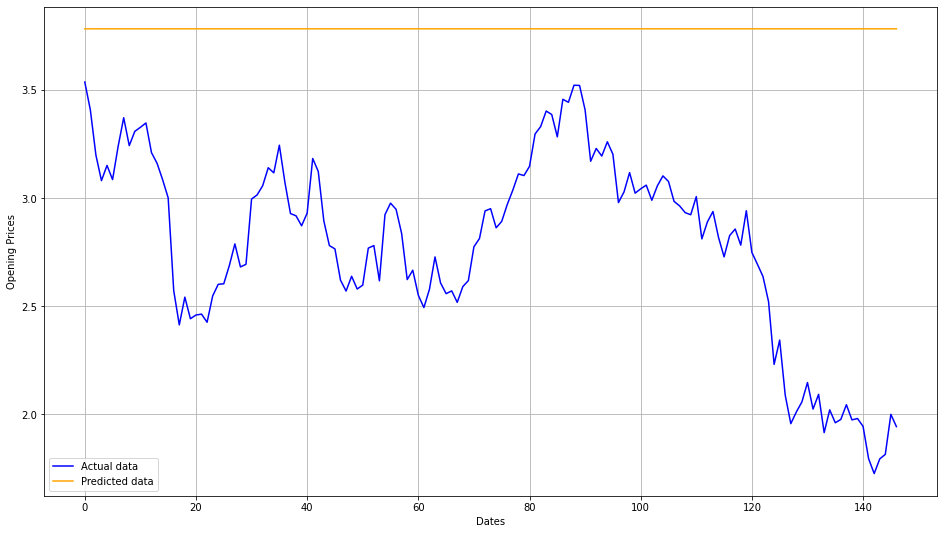

In [14]:
pred_series = pd.Series(pred, index=index_test)

plt.figure(figsize=(16, 9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Opening Prices')
plt.plot(inv_test, 'blue', label='Actual data')
plt.plot(inv_pred, 'orange', label='Predicted data')
plt.legend()

# Đánh giá mô hình

In [15]:
mae = mean_absolute_error(inv_test, inv_pred)
mape = mean_absolute_percentage_error(inv_test, inv_pred)
mse = mean_squared_error(inv_test, inv_pred)
rmse = np.sqrt(mse)
r2 = r2_score(inv_test, inv_pred)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 1.00
MAPE: 39.62%
MSE: 1.18
RMSE: 1.09
R2: -5.31


# Tạo một DataFrame là 'df_pred' để lưu kết quả dự đoán trên mô hình ARIMA

In [16]:
df_pred = pd.DataFrame(index=index_test)
df_pred['Actual'] = inv_test
df_pred['ARIMA'] = inv_pred
df_pred['Error'] = inv_test - inv_pred
df_pred

,Actual,ARIMA,Error
Date,,,
2022-01-06,3.53615,3.782006,-0.245856
2022-01-07,3.40722,3.782312,-0.375092
2022-01-08,3.19814,3.782274,-0.584134
2022-01-09,3.07989,3.782279,-0.702389
2022-01-10,3.15027,3.782278,-0.632008
...,...,...,...
2022-05-28,1.72467,3.782278,-2.057608
2022-05-29,1.79225,3.782278,-1.990028
2022-05-30,1.81356,3.782278,-1.968718


## 2. Quá trình dự đoán trên mô hình LSTM

# Tạo thêm một DataFrame để tiến hành dự đoán sai số trên mô hình LSTM

In [17]:
df_lstm = df_pred.copy()
df_lstm

,Actual,ARIMA,Error
Date,,,
2022-01-06,3.53615,3.782006,-0.245856
2022-01-07,3.40722,3.782312,-0.375092
2022-01-08,3.19814,3.782274,-0.584134
2022-01-09,3.07989,3.782279,-0.702389
2022-01-10,3.15027,3.782278,-0.632008
...,...,...,...
2022-05-28,1.72467,3.782278,-2.057608
2022-05-29,1.79225,3.782278,-1.990028
2022-05-30,1.81356,3.782278,-1.968718


# Vẽ đồ thị thể hiện sai số

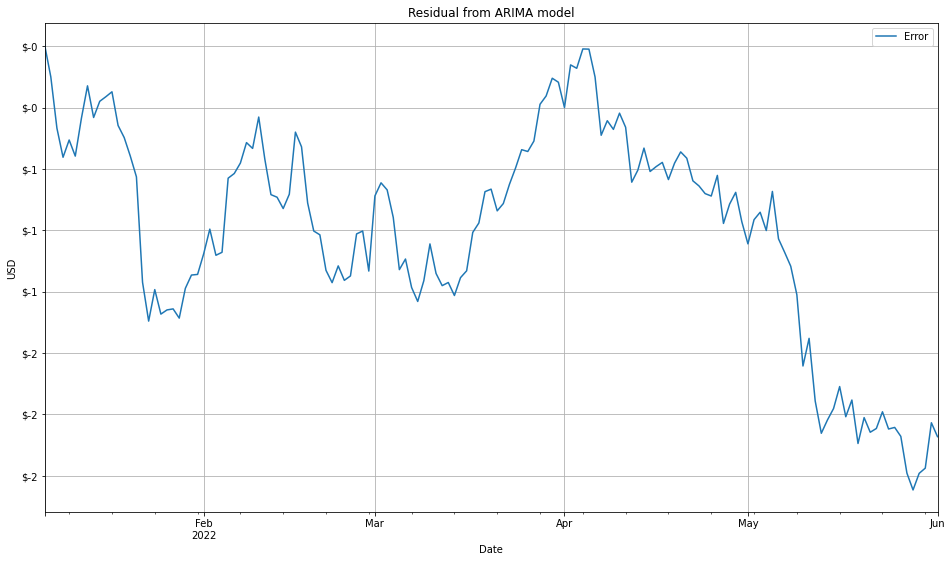

In [18]:
formatter = ticker.StrMethodFormatter('${x:,.0f}')

error = df_lstm[['Error']]
title = 'Residual from ARIMA model'
ylabel = 'USD'
xlabel = 'Date'

ax = error.plot(figsize=(16, 9), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True)

In [19]:
error = np.array(error)
error

array([[-0.24585619],
       [-0.375092  ],
       [-0.58413404],
       [-0.70238875],
       [-0.63200817],
       [-0.69763824],
       [-0.54405823],
       [-0.41140823],
       [-0.54032823],
       [-0.47443823],
       [-0.45577823],
       [-0.43564823],
       [-0.57284823],
       [-0.62212823],
       [-0.69779823],
       [-0.78206823],
       [-1.21160823],
       [-1.36975823],
       [-1.24146823],
       [-1.34126823],
       [-1.32420823],
       [-1.32002823],
       [-1.35761823],
       [-1.23632823],
       [-1.18215823],
       [-1.17956823],
       [-1.09545823],
       [-0.99511823],
       [-1.10161823],
       [-1.08947823],
       [-0.78753823],
       [-0.76852823],
       [-0.72598823],
       [-0.64262823],
       [-0.66636823],
       [-0.53854823],
       [-0.71047823],
       [-0.85463823],
       [-0.86511823],
       [-0.91121823],
       [-0.85298823],
       [-0.59995823],
       [-0.65994823],
       [-0.88849823],
       [-1.00283823],
       [-1

In [20]:
look_back = 3
x_total, y_total = [], []
for i in range(look_back, len(error)):
	x_total.append(error[i-look_back:i])
	y_total.append(error[i])
x_train = np.array(x_total[:len(error)])
y_train = np.array(y_total[:len(error)])

print("x_train",x_train.shape)
print("y_train",y_train.shape)


x_train (144, 3, 1)
y_train (144, 1)


In [21]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(x_train, y_train, epochs=300, verbose=1)
model.save("ethereum_8_2.h5")

Epoch 1/300
5/5 [==============================] - 3s 7ms/step - loss: 1.1442
Epoch 2/300
5/5 [==============================] - 0s 7ms/step - loss: 1.0572
Epoch 3/300
5/5 [==============================] - 0s 6ms/step - loss: 0.9613
Epoch 4/300
5/5 [==============================] - 0s 7ms/step - loss: 0.8508
Epoch 5/300
5/5 [==============================] - 0s 6ms/step - loss: 0.7184
Epoch 6/300
5/5 [==============================] - 0s 5ms/step - loss: 0.5577
Epoch 7/300
5/5 [==============================] - 0s 5ms/step - loss: 0.3563
Epoch 8/300
5/5 [==============================] - 0s 5ms/step - loss: 0.1749
Epoch 9/300
5/5 [==============================] - 0s 5ms/step - loss: 0.0399
Epoch 10/300
5/5 [==============================] - 0s 5ms/step - loss: 0.0619
Epoch 11/300
5/5 [==============================] - 0s 7ms/step - loss: 0.0562
Epoch 12/300
5/5 [==============================] - 0s 6ms/step - loss: 0.0264
Epoch 13/300
5/5 [==============================] - 0s 6ms/st

In [22]:
model = load_model("ethereum_8_2.h5")
error_pred = model.predict(x_train)
error_pred

5/5 [==============================] - 0s 3ms/step


array([[-0.48901746],
       [-0.6045663 ],
       [-0.6751497 ],
       [-0.70374763],
       [-0.66496944],
       [-0.6102137 ],
       [-0.5653449 ],
       [-0.54994315],
       [-0.56173   ],
       [-0.53570884],
       [-0.5562457 ],
       [-0.5985499 ],
       [-0.666453  ],
       [-0.7220414 ],
       [-0.88761926],
       [-1.0981584 ],
       [-1.2323946 ],
       [-1.2732793 ],
       [-1.2616503 ],
       [-1.2839842 ],
       [-1.2913724 ],
       [-1.2582499 ],
       [-1.2114407 ],
       [-1.1585203 ],
       [-1.1139163 ],
       [-1.0547823 ],
       [-1.0340207 ],
       [-1.0342047 ],
       [-0.96748745],
       [-0.87087595],
       [-0.7720923 ],
       [-0.73339736],
       [-0.7050777 ],
       [-0.6579993 ],
       [-0.6716502 ],
       [-0.7216743 ],
       [-0.81323856],
       [-0.86932814],
       [-0.8691403 ],
       [-0.7959671 ],
       [-0.72546726],
       [-0.73310524],
       [-0.84773237],
       [-0.9514508 ],
       [-1.034091  ],
       [-1

In [23]:
df_lstm = df_lstm.copy().head(len(error_pred))
df_lstm['Error Prediction'] = error_pred
df_lstm

,Actual,ARIMA,Error,Error Prediction
Date,,,,
2022-01-06,3.53615,3.782006,-0.245856,-0.489017
2022-01-07,3.40722,3.782312,-0.375092,-0.604566
2022-01-08,3.19814,3.782274,-0.584134,-0.675150
2022-01-09,3.07989,3.782279,-0.702389,-0.703748
2022-01-10,3.15027,3.782278,-0.632008,-0.664969
...,...,...,...,...
2022-05-25,1.97940,3.782278,-1.802878,-1.880224
2022-05-26,1.94289,3.782278,-1.839388,-1.977598
2022-05-27,1.79319,3.782278,-1.989088,-2.012430


In [24]:
df_lstm['ARIMA_LSTM'] = df_lstm['ARIMA'] + df_lstm['Error Prediction']
df_lstm

,Actual,ARIMA,Error,Error Prediction,ARIMA_LSTM
Date,,,,,
2022-01-06,3.53615,3.782006,-0.245856,-0.489017,3.292989
2022-01-07,3.40722,3.782312,-0.375092,-0.604566,3.177746
2022-01-08,3.19814,3.782274,-0.584134,-0.675150,3.107124
2022-01-09,3.07989,3.782279,-0.702389,-0.703748,3.078531
2022-01-10,3.15027,3.782278,-0.632008,-0.664969,3.117309
...,...,...,...,...,...
2022-05-25,1.97940,3.782278,-1.802878,-1.880224,1.902054
2022-05-26,1.94289,3.782278,-1.839388,-1.977598,1.804680
2022-05-27,1.79319,3.782278,-1.989088,-2.012430,1.769849


# Vẽ đồ thị

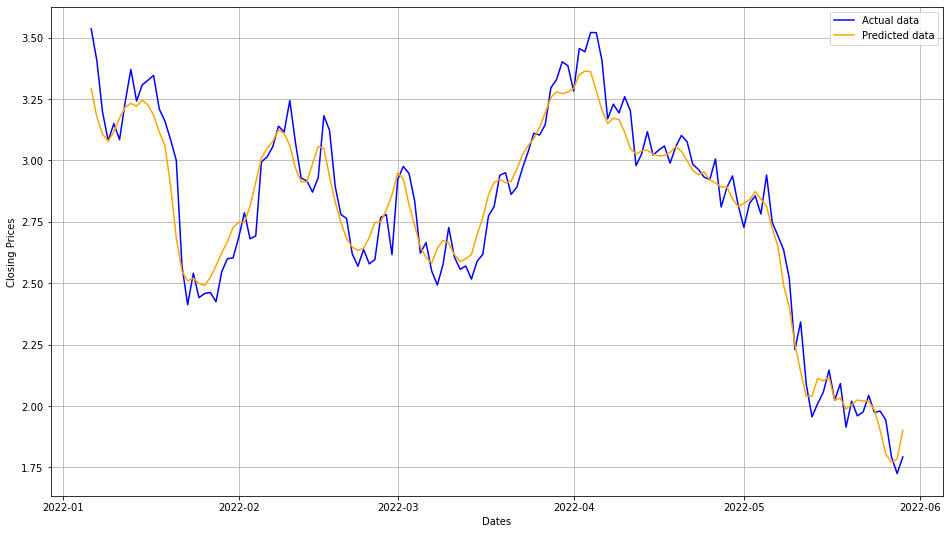

In [25]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_lstm['Actual'], 'blue', label='Actual data')
plt.plot(df_lstm['ARIMA_LSTM'], 'orange', label='Predicted data')
plt.legend()

# Đánh giá mô hình

In [26]:
mae = mean_absolute_error(df_lstm.Actual, df_lstm.ARIMA_LSTM)
mape = mean_absolute_percentage_error(df_lstm.Actual, df_lstm.ARIMA_LSTM)
mse = mean_squared_error(df_lstm.Actual, df_lstm.ARIMA_LSTM)
rmse = np.sqrt(mse)
r2 = r2_score(df_lstm.Actual, df_lstm.ARIMA_LSTM)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 0.07
MAPE: 2.66%
MSE: 0.01
RMSE: 0.10
R2: 0.95


# Lấy 3 ngày cuối ra để dự báo

In [27]:
forecast = df_lstm['Error'].tail(3)
forecast

Date
2022-05-27   -1.989088
2022-05-28   -2.057608
2022-05-29   -1.990028
Name: Error, dtype: float64

# Đưa về ma trận

In [28]:
dataX = []
for i in range(len(forecast)):
    a=forecast[i]
    dataX.append(a)
dataX = np.array(dataX).reshape(1,-1,1)
dataX

array([[[-1.98908823],
        [-2.05760823],
        [-1.99002823]]])

In [29]:
y_forecast= model.predict(dataX).reshape(1,)
y_forecast

1/1 [==============================] - 0s 23ms/step


array([-2.0124297], dtype=float32)

# So sánh kết quả dự đoán với giá trị thực

In [30]:
y_arima = df_pred.copy()
y_arima = y_arima.tail(4).head(1)
y_arima

,Actual,ARIMA,Error
Date,,,
2022-05-29,1.79225,3.782278,-1.990028


In [31]:
y_arima['Final_LSTM'] = y_arima.ARIMA + y_forecast
y_arima

,Actual,ARIMA,Error,Final_LSTM
Date,,,,
2022-05-29,1.79225,3.782278,-1.990028,1.769849


# Ghi ra file csv

In [32]:
df.to_csv("eth_processed_data_8_2.csv")
df_scaled.to_csv("eth_scaled_data_8_2.csv")
df_pred.to_csv("eth_ARIMA-PRED_8_2.csv")
df_lstm.to_csv("eth_LSTM_PRED_8_2.csv")
y_arima.to_csv("eth_Forecast_8_2.csv")